In [67]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt


In [68]:
ames = pd.read_csv("AmesHousing.csv")
good_cols = ames.isna().sum() < 100
ames = ames.loc[:, good_cols]
ames = ames.dropna()

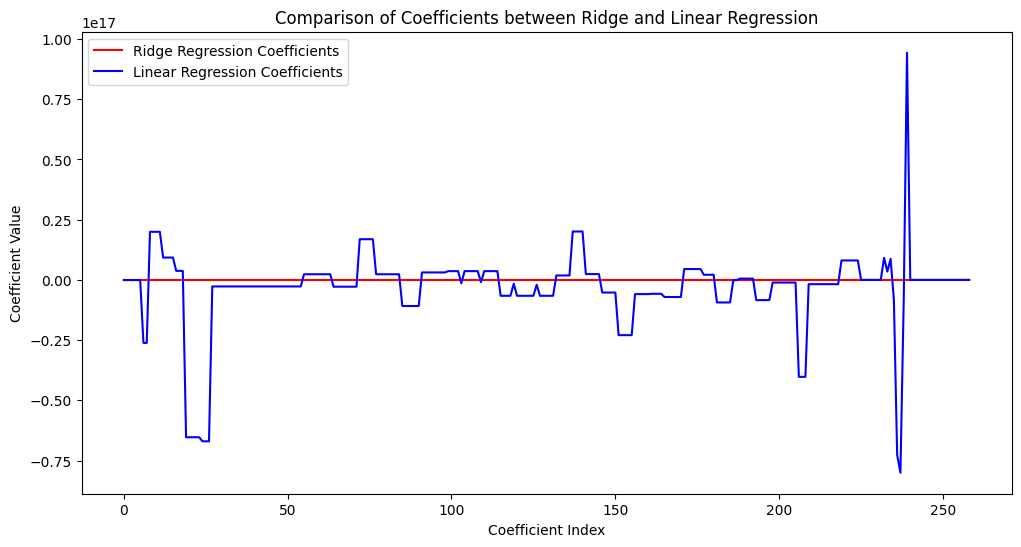

Ridge Regression Cross-Validation R-squared Scores: [0.8983804  0.91749817 0.79251623 0.78248152 0.91492025]
0.8611593144036662
Linear Regression Cross-Validation R-squared Scores: [-4.59217770e+20 -1.21723181e+20 -8.37868327e+19 -9.71584476e+20
 -3.78389822e+20]
-4.0294041643340005e+20


In [69]:
X = ames.drop(["SalePrice", "Order", "PID"], axis=1)
y = ames["SalePrice"]

ct = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]
)

ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')

lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)
lr_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')

ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

lr_pipeline.fit(X, y)
lr_coefs = lr_pipeline.named_steps['linear_regression'].coef_

plt.figure(figsize=(12, 6))
plt.plot(ridge_coefs, 'r', label='Ridge Regression Coefficients')
plt.plot(lr_coefs, 'b', label='Linear Regression Coefficients')
plt.legend()
plt.title('Comparison of Coefficients between Ridge and Linear Regression')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.show()

print("Ridge Regression Cross-Validation R-squared Scores:", ridge_scores)
print(np.mean(ridge_scores))
print("Linear Regression Cross-Validation R-squared Scores:", lr_scores)
print( np.mean(lr_scores))

In [70]:

# Define the Ridge Regression pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge())]
)

# Define the grid of lambda values for tuning
alpha_grid = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

# Set up GridSearchCV for tuning Ridge Regression within the pipeline
grid_search = GridSearchCV(ridge_pipeline, param_grid=alpha_grid, cv=5, scoring='r2')

# Fit GridSearchCV to the data
grid_search.fit(X, y)

# Best alpha (lambda) value and corresponding R-squared score
best_alpha = grid_search.best_params_['ridge_regression__alpha']
best_score = grid_search.best_score_

# Output the results
print("Best alpha (lambda):", best_alpha)
print("R-squared Score:", best_score)


Best alpha (lambda): 10
R-squared Score: 0.8633548524419264


In [71]:
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge())]
)

alphas = [0.001, 0.01, 0.1, 1, 10]

param_grid = {
    'ridge_regression__alpha': alphas
}

grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)
best_alpha = grid_search.best_params_['ridge_regression__alpha']
print("Best Lambda:", best_alpha)

Best Lambda: 10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+11, tolerance: 1.463e

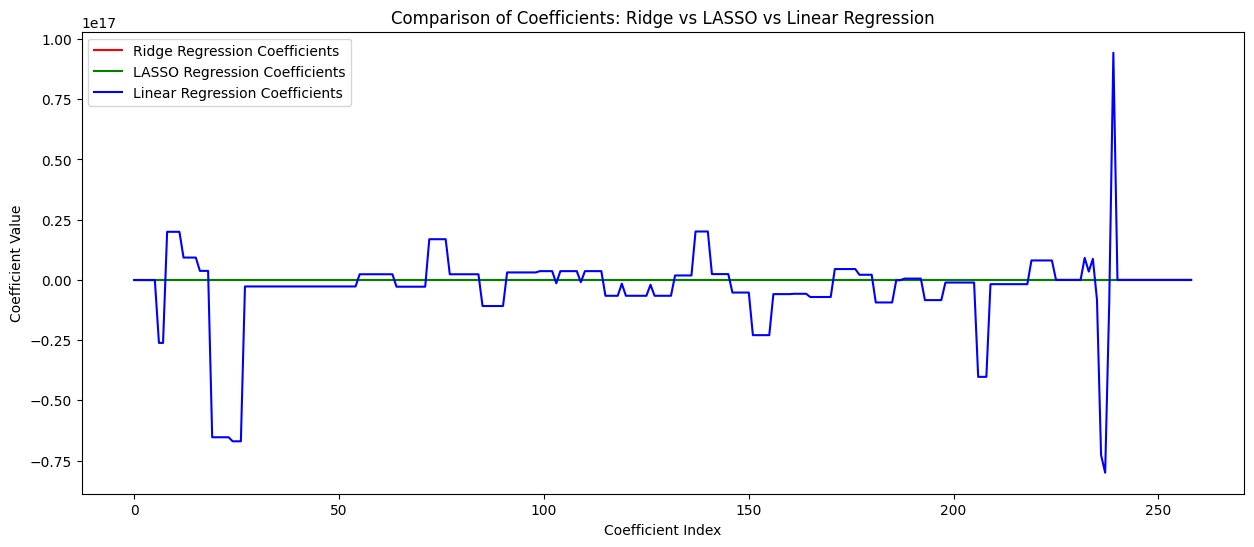

(10, 0.8594950842585085)

In [72]:

lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso())]
)
lasso_alpha_grid = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid=lasso_alpha_grid, cv=5, scoring='r2')

lasso_grid_search.fit(X, y)

best_lasso_alpha = lasso_grid_search.best_params_['lasso_regression__alpha']
best_lasso_score = lasso_grid_search.best_score_

best_lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=best_lasso_alpha))]
)
best_lasso_pipeline.fit(X, y)
lasso_coefs = best_lasso_pipeline.named_steps['lasso_regression'].coef_
coefs_comparison = pd.DataFrame({
    'Ridge': ridge_coefs,
    'LASSO': lasso_coefs,
    'Linear Regression': lr_coefs
})

plt.figure(figsize=(15, 6))
plt.plot(coefs_comparison['Ridge'], 'r', label='Ridge Regression Coefficients')
plt.plot(coefs_comparison['LASSO'], 'g', label='LASSO Regression Coefficients')
plt.plot(coefs_comparison['Linear Regression'], 'b', label='Linear Regression Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Coefficients: Ridge vs LASSO vs Linear Regression')
plt.legend()
plt.show()

best_lasso_alpha, best_lasso_score


The lambda of 10 netted the highest mean R2 test score 0.8594950842585085.

In [73]:
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

alphas = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.001, 0.01, 0.1]}

gscv = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_['mean_test_score']

results = pd.DataFrame(gscv_fitted.cv_results_)
df_elastic = results.loc[:, ['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_test_score']]
best_row = results.loc[results['mean_test_score'].idxmax()]
best_score = best_row['mean_test_score']
best_params = best_row['params']
print(f"The best mean test score is {best_score}")
print(f"The best parameters are {best_params}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.277e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.083e+11, tolerance: 1.463e

The best mean test score is 0.8629031306340172
The best parameters are {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.1}


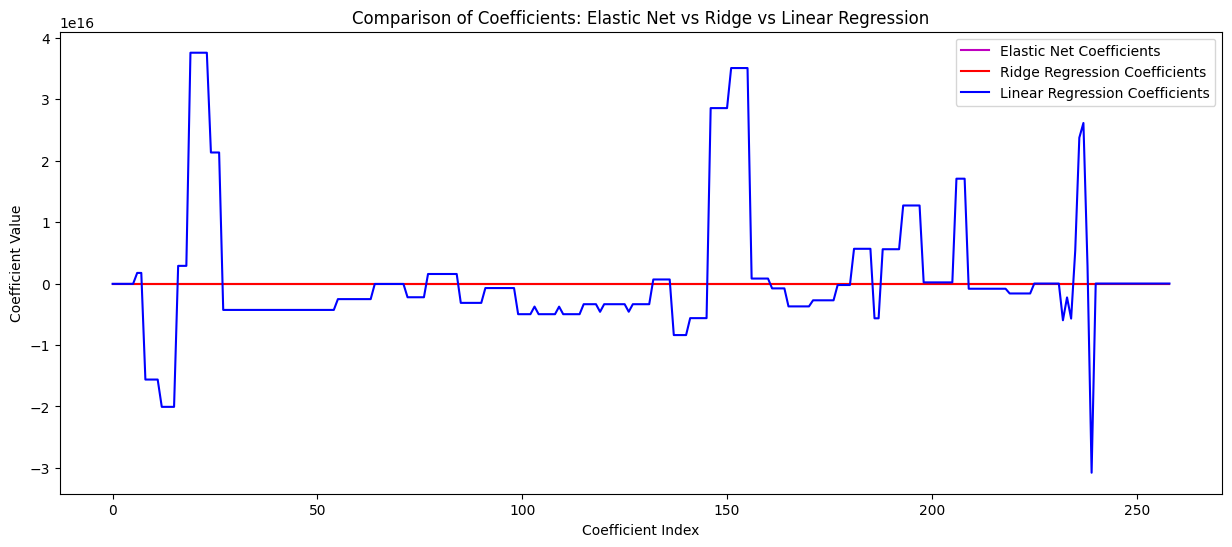

In [74]:
best_elastic_alpha = gscv.best_params_['elastic_net__alpha']
best_l1_ratio = gscv.best_params_['elastic_net__l1_ratio']
elastic_net_pipeline.set_params(elastic_net__alpha=best_elastic_alpha, elastic_net__l1_ratio=best_l1_ratio)
elastic_net_pipeline.fit(X, y)
elastic_net_coefs = elastic_net_pipeline.named_steps['elastic_net'].coef_

ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

lr_pipeline.fit(X, y)
lr_coefs = lr_pipeline.named_steps['linear_regression'].coef_
coefs_comparison = pd.DataFrame({
    'Elastic Net': elastic_net_coefs,
    'Ridge': ridge_coefs,
    'Linear Regression': lr_coefs
})
plt.figure(figsize=(15, 6))
plt.plot(coefs_comparison['Elastic Net'], 'm', label='Elastic Net Coefficients')
plt.plot(coefs_comparison['Ridge'], 'r', label='Ridge Regression Coefficients')
plt.plot(coefs_comparison['Linear Regression'], 'b', label='Linear Regression Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Coefficients: Elastic Net vs Ridge vs Linear Regression')
plt.legend()
plt.show()
